<p style="font-size:16px;text-align:left"> <b>Modelling</b> </p>

Models
- XGBOOST
- Random Forest 

In [1]:
#Importing Libraries

import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime 
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import pdb
from pandas import HDFStore, DataFrame, read_hdf
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import randint as sp_randint
from scipy.stats import uniform

import networkx as nx # library to study graphs and networks

In [159]:
# reading the train_graph

if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [179]:
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [180]:
print(df_final_train.shape)
df_final_train.head(3)

(100002, 54)


,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-2.380564e-19,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19


In [181]:
print(df_final_test.shape)
df_final_test.head(3)

(50002, 54)


,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,848424,784690,1,0,0.0,0.029161,0.0,14,6,9,...,5.904807e-11,2.701538e-12,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12
1,483294,1255532,1,0,0.0,0.000000,0.0,17,1,19,...,2.545382e-10,2.248568e-14,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14
2,626190,1729265,1,0,0.0,0.000000,0.0,10,16,9,...,1.122150e-05,1.778927e-12,2.740535e-13,4.199834e-14,-4.253075e-13,4.789463e-13,3.479824e-07,1.630549e-13,3.954708e-13,3.875785e-14


In [182]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

## 1. Adding 2 new features
- Preferential Attachment
- SVD Dot

### 1.1 Preferential Attachment

Preferential Attachment: Users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. It may be noted that the similarity index does not require any node neighbor information; therefore, this similarity index has the lowest computational complexity.

http://be.amazd.com/link-prediction/

In [183]:
# Adding Preferential Attachment with followers and followees data of vertex in both train and test data

def compute_preferential(df_final):
    # calculating no of followers followees for source and destination
    # calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    
    preferential_followers = []
    preferential_followees = []
    
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
            
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))
        
        preferential_followers.append(len(s1) * len(d1))
        preferential_followees.append(len(s2) * len(d2))
        
    return preferential_followers, preferential_followees

In [184]:
# mapping Preferential Attachment followers and followees to train and test data

df_final_train['preferential_followers'], df_final_train['preferential_followees'] = compute_preferential(df_final_train)
df_final_test['preferential_followers'], df_final_test['preferential_followees'] = compute_preferential(df_final_test)

In [185]:
# normalizing the Preferential Attachment features

def normalise(df, column):
    
    # apply normalization techniques
    df[column] = MinMaxScaler().fit_transform(np.array(df[column]).reshape(-1,1))

In [186]:
normalise(df_final_train, 'preferential_followers')
normalise(df_final_train, 'preferential_followees')
normalise(df_final_test, 'preferential_followers')
normalise(df_final_test, 'preferential_followees')

In [187]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers,preferential_followees
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,0.000618,0.001429
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,0.014954,0.103119


In [188]:
df_final_test.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers,preferential_followees
0,848424,784690,1,0,0.0,0.029161,0.0,14,6,9,...,4.341620e-13,5.535503e-14,-9.994076e-10,5.791910e-10,3.512364e-07,2.486658e-09,2.771146e-09,1.727694e-12,0.000928,0.000276
1,483294,1255532,1,0,0.0,0.000000,0.0,17,1,19,...,3.600957e-13,4.701436e-15,-9.360516e-12,3.206809e-10,4.668696e-08,6.665777e-12,1.495979e-10,9.836670e-14,0.000376,0.000097


### 1.2 SVD Dot

Dot product between source node svd and destination node svd features. 

https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf

In [189]:
# Adding svd_dot feature i.e the dot product between source node svd and destination node svd features in both train and test data

def compute_svd_dot(df):
    
    t_s = df[['svd_u_s_1','svd_u_s_2','svd_u_s_3','svd_u_s_4','svd_u_s_5','svd_u_s_6',
                         'svd_v_s_1','svd_v_s_2','svd_v_s_3','svd_v_s_4','svd_v_s_5','svd_v_s_6',]]
    t_d = df[['svd_u_d_1','svd_u_d_2','svd_u_d_3','svd_u_d_4','svd_u_d_5','svd_u_d_6',
                         'svd_v_d_1','svd_v_d_2','svd_v_d_3','svd_v_d_4','svd_v_d_5','svd_v_d_6',]]
    
    t_s['combined_s']= t_s.values.tolist()
    t_s['combined_d']= t_d.values.tolist()
    t_s['total'] = [np.dot(x, y) for x, y in zip(t_s.combined_s, t_s.combined_d)]
    
    return t_s['total']

In [190]:
%%time
df_final_train['svd_dot'] = compute_svd_dot(df_final_train)
df_final_test['svd_dot'] = compute_svd_dot(df_final_test)

CPU times: user 8.81 s, sys: 120 ms, total: 8.93 s
Wall time: 8.91 s


In [195]:
df_final_train.head(3)

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_followers,preferential_followees,svd_dot
0,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,...,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,0.000618,0.001429,1.338835e-11
1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,...,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,0.014954,0.103119,4.099684e-03
2,0,0.369565,0.156957,0.566038,28,41,22,26,17,10.991826,...,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19,0.009171,0.010738,2.034290e-35


## 2. Modelling

### 2.1 XGBOOST

In [135]:
# Finding best parameters using RandomizedSearchCV

x_cfl=XGBClassifier(random_state=10, n_jobs=-1)

prams={
    'learning_rate':[0.01,0.03,0.1],
     'n_estimators':[200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.3,0.5,1],
    'subsample':[0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=1,n_jobs=-1)
random_cfl.fit(df_final_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 50.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 89.1min finished


[18:12:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           num_parallel_tree=None,
                                           random_state=10, reg_alpha=None,
                                           reg_lambda=Non

In [136]:
print(random_cfl.best_params_)

{'subsample': 0.5, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.03, 'colsample_bytree': 1}


In [147]:
# Training the model using the best hyperparameters

x_cfl=XGBClassifier(n_estimators=1000, max_depth=5,learning_rate=0.03,colsample_bytree=1,subsample=0.5,n_jobs=-1)

In [148]:
x_cfl.fit(df_final_train, y_train)

[18:29:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [149]:
y_train_pred = x_cfl.predict(df_final_train)
y_test_pred = x_cfl.predict(df_final_test)

In [150]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9916873063463255
Test f1 score 0.9216704047847911


**Observation:** The XGBoost model seems to be overfitting on the train data

In [153]:
# saving the best model

filename = 'xgboost.sav'
pickle.dump(x_cfl, open(filename, 'wb'))

Train confusion_matrix


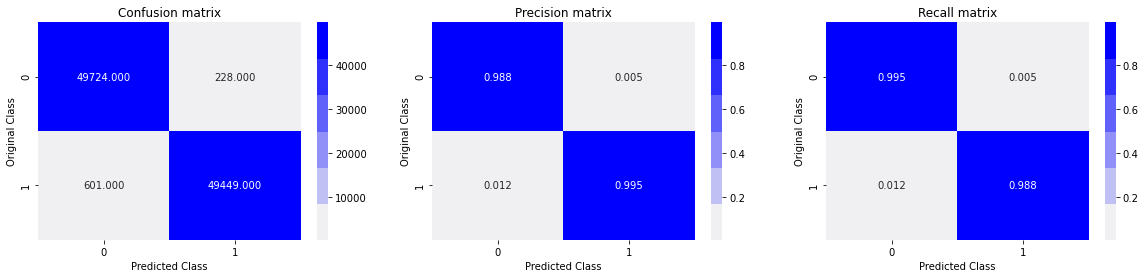

Test confusion_matrix


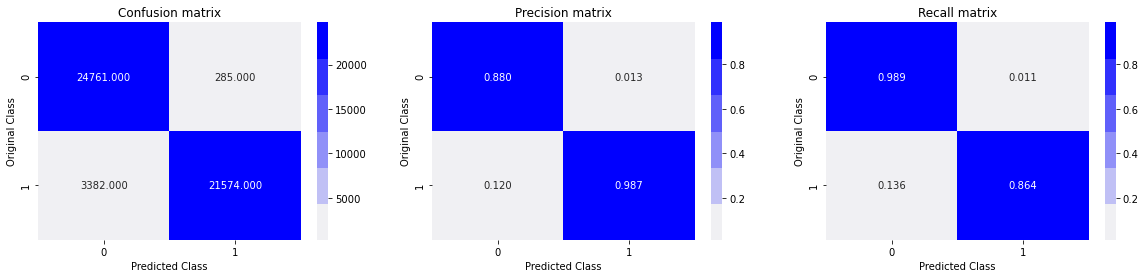

In [152]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

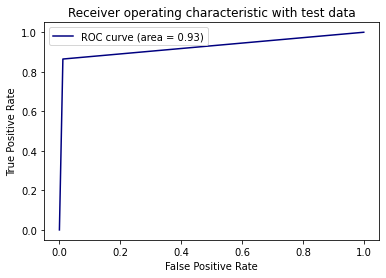

In [154]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

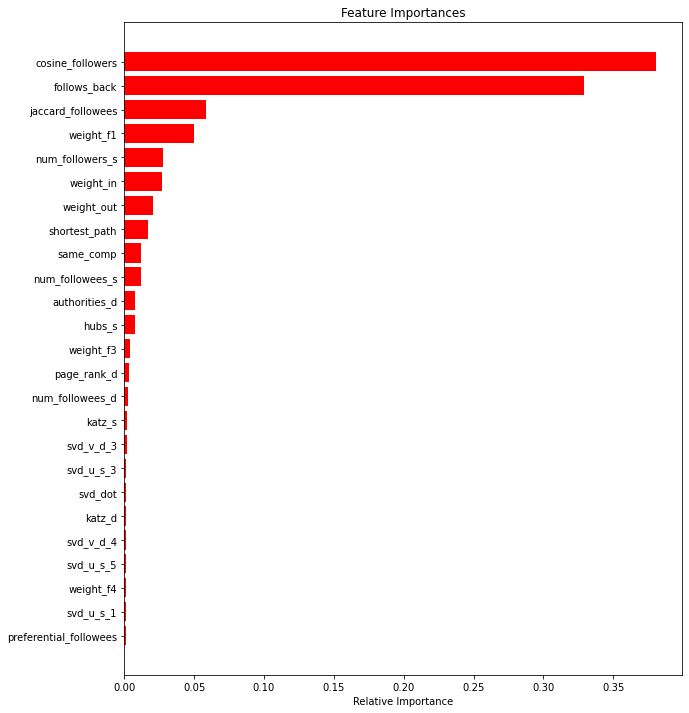

In [155]:
features = df_final_train.columns
importances = x_cfl.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### 2.2 Random Forest

#### 2.2.1 GridSearchCV on the number of estimators

In [114]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)

Estimators =  10 Train Score 0.9171651563563983 test Score 0.882394714756074
Estimators =  50 Train Score 0.9177223128057194 test Score 0.9128418224936514
Estimators =  100 Train Score 0.9187557449653213 test Score 0.9142521452699158
Estimators =  250 Train Score 0.9204207183965072 test Score 0.9157693680078921
Estimators =  450 Train Score 0.9211365037566486 test Score 0.9164619680460204


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

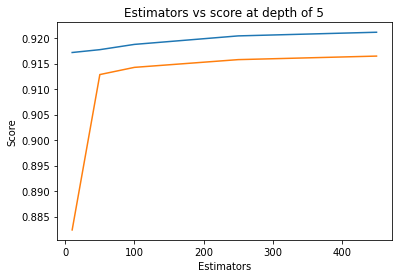

In [115]:
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

#### 2.2.2 GridSearchCV on depth

depth =  3 Train Score 0.8863741049369791 test Score 0.863217454670153
depth =  9 Train Score 0.9573994692794449 test Score 0.92279776347716
depth =  11 Train Score 0.9613066145324208 test Score 0.921652752826799
depth =  15 Train Score 0.9636924200320481 test Score 0.9231254866474462
depth =  20 Train Score 0.9648982078489111 test Score 0.9267370013870793
depth =  35 Train Score 0.9645558567613942 test Score 0.9266714291717444
depth =  50 Train Score 0.9645558567613942 test Score 0.9266714291717444
depth =  70 Train Score 0.9645558567613942 test Score 0.9266714291717444
depth =  130 Train Score 0.9645558567613942 test Score 0.9266714291717444


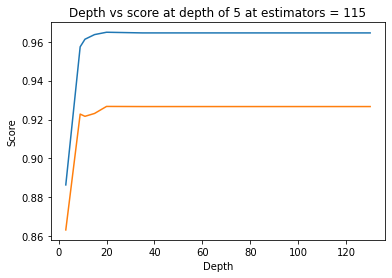

In [116]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

#### 2.2.3 Hyperparameter tuning with RandomizedSearchCV

In [120]:
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)

In [121]:
print('mean test scores',rf_random.cv_results_['mean_test_score'])

mean test scores [0.96245691 0.96160705 0.96036682 0.96178131 0.96350551]


In [122]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [123]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [124]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [125]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9645512358889576
Test f1 score 0.9257673090649536


In [126]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


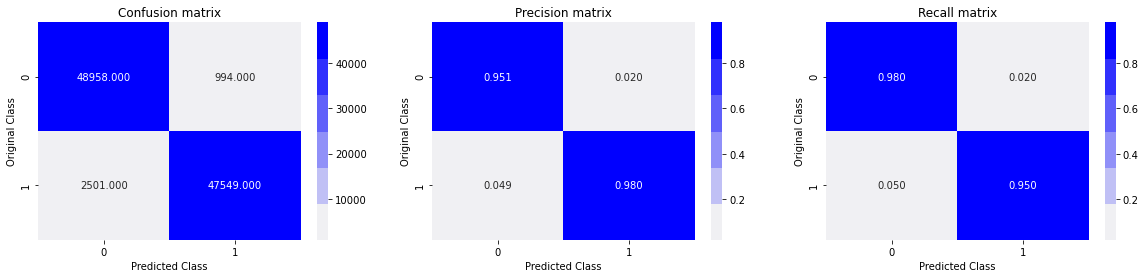

Test confusion_matrix


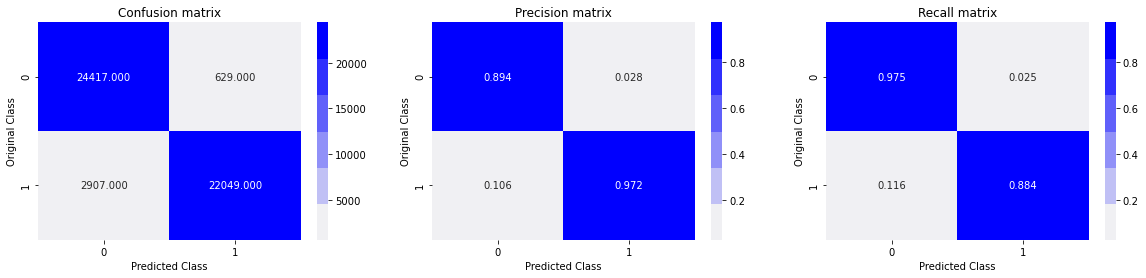

In [127]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

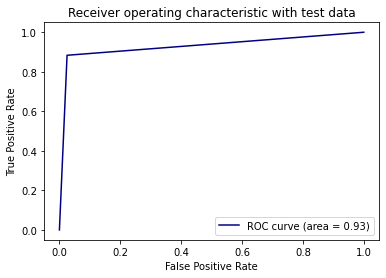

In [128]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

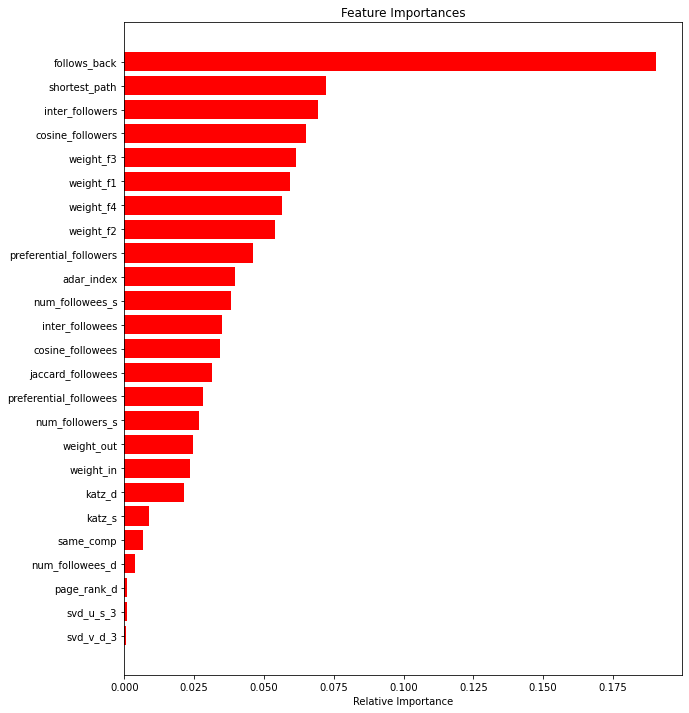

In [129]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 3. Summary
1. The XGBoost model seems to be overfitting on the train data
2. After hyperparameter tuning with RandomSearchCV, the RF model makes predictions with an F1 score of ~0.92  & AUC score of ~ 0.93 on test data
4. Features like follows_back, shortest_path, inter_followers are some of the most important features in the feature set
5. Newly added preferential_followers & preferential_followees features also play a significant role towards the output prediction
6. The svd features have negligible impact on the predictions 